In [ ]:
#발표자 전호영
#메인 및 응용코드 김기종
#서브코드 이인혁

In [ ]:
#구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import torch   #초기 설정
import numpy as np
from torch import nn, optim
from torch.utils.data import (Dataset, DataLoader, TensorDataset)
import tqdm
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt

In [ ]:
#데이터 크기 재조정, 텐서변환, 정규화
trans = transforms.Compose([transforms.Resize((100, 100)),
                             transforms.ToTensor(),
                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                             ])

#데이터 가져오기, 및 위에 형식처럼 변환
masktrain = torchvision.datasets.ImageFolder(root = '/content/drive/MyDrive/Project_mask/masktrain/train/',
                                             transform = trans)
masktest = torchvision.datasets.ImageFolder(root = '/content/drive/MyDrive/Project_mask/masktest/test/',
                                             transform = trans)

In [ ]:
print(len(masktrain))

In [ ]:
print(len(masktest))

In [ ]:
#배치사이즈 10
batch_size = 10

#학습률 0.001
learning_rate = 0.001

#트레이닝 에포트 20
training_epochs = 20

In [ ]:
#데이터 로더로 데이터 로드하기
#셔플:사용
#드롭 라스트:제일 마지막 batch가 batch 수 보다 작을 경우 그냥 그 배치를 버리는 기

masktrain_loader = torch.utils.data.DataLoader(dataset = masktrain,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=True)
masktest_loader = torch.utils.data.DataLoader(dataset = masktest,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=True)

In [ ]:
#사용 데이터셋 미리보기
dataiter = iter(masktrain_loader)
images, labels = dataiter.next()
print(labels)

In [ ]:
imshow(torchvision.utils.make_grid(images, nrow = 4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)

In [ ]:
def imshow(img):
  img = img / 2 + 0.5 #unnormalize
  np_img = img.numpy()
  #plt.imshow(np_img)
  plt.imshow(np.transpose(np_img, (1,2,0)))

  print(np_img.shape)
  print((np.transpose(np_img, (1, 2, 0))).shape)

In [ ]:
class Net(nn.Module):
  def forward(self, x):
    sizes = x.size()
    return x.view(sizes[0], -1)
#5x5 의 커널을 사용해 처음에는 32개, 다음에는 64개의 채널 작성
#BatchNorm2d 는 이미지용 Batch Normalization
#Dropout2d는 이미지용 Dropout2d마지막으로 Net적용
conv_net = nn.Sequential(
    nn.Conv2d(3, 32, 5),  #3차원 이미지  32채널로, 커널사이즈는 5
    nn.MaxPool2d(2),  #MaxPool2d를 통한 커널사이즈에서 가장 큰값을 뽑아 이미지 크기는 줄이되 데이터 손실 줄이기
    nn.ReLU(), #ReLU(렐루)함수 사용
    nn.BatchNorm2d(32), #배치정규화를 통한 가중치 초기값 선택 의존성 줄이기(학습할때마다 출력값을 정규화하기때문), 과적합 방지
    nn.Dropout2d(0.3), #드롭아웃을 통한 오버피팅(과적화)문제 해결

    nn.Conv2d(32, 64, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Dropout2d(0.3),
    Net()
)

In [ ]:
test_input = torch.ones(5, 3, 100, 100)
conv_output_size = conv_net(test_input).size()[-1]
#2층 mlp(다층 퍼셉트론)
mlp = nn.Sequential(
    nn.Linear(conv_output_size, 200),#입력받은 데이터에 선형변환 적용
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Dropout(0.3),
    nn.Linear(200, 10)
)
#최종 CNN Model
net = nn.Sequential(
    conv_net,
    mlp
)

In [ ]:
def eval_net(net, data_loader, device = 'cpu'):
  #Dropout 및 Batchnorm을 무효화
  net.eval()
  ys = []
  ypreds = []
  for x, y in data_loader:
    x = x.to(device)
    y = y.to(device)
    with torch.no_grad():
      _, y_pred = net(x).max(1)
    ys.append(y)
    ypreds.append(y_pred)
#미니배치 단위의 예측 결과 등을 하나로 묶기
  ys = torch.cat(ys)
  ypreds = torch.cat(ypreds)
#예측 정학도 계산
  acc = (ys == ypreds).float().sum() / len(ys)
  return acc.item()

In [ ]:
#훈련용 헬퍼 함수
def train_net(net, masktrain_loader, masktest_loader,
              optimizer_cls = optim.Adam,     #옵티마이저함수: Adam사용
              loss_fn = nn.CrossEntropyLoss(),#손실함수:  CrossEntropyLoss사용(다중분류를 위한 대표적 손실함수)
              n_iter = 20,                    #데이터 훈련 횟수
              device = 'cpu'):
  train_losses = []                           #훈련 손실률
  train_acc = []                              #훈련 정확도
  val_acc = []                                #검증 예측 정확도
  optimizer = optimizer_cls(net.parameters())
  for epoch in range(n_iter):                 #훈련시작
    running_loss = 0.0
    #신경망 훈련모드 설정
    net.train()
    n = 0
    n_acc = 0
    #시간이 많이 걸리므로 tqdm을 사용해 진행도를 표시
    for i, (xx, yy) in tqdm.tqdm(enumerate(masktrain_loader),
                                 total = len(masktrain_loader)):
      xx = xx.to(device)
      yy = yy.to(device)
      h = net(xx)
      loss = loss_fn(h, yy)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      n +=len(xx)
      _, y_pred = h.max(1)
      n_acc += (yy == y_pred).float().sum().item()
    #훈련데이터 손실률
    train_losses.append(running_loss / i)
    #훈련데이터 예측 정확도
    train_acc.append(n_acc / n)

    #검증데이터 예측 정확도
    val_acc.append(eval_net(net, masktest_loader, device))
    #에포크 결과 표시
    print(epoch, train_losses[-1], train_acc[-1],
          val_acc[-1], flush = True)

In [ ]:
#GPU 연산
#신경망의 모든 파라미터 GPU로 전송
net.to('cuda:0')

#훈련실행
train_net(net, masktrain_loader, masktest_loader, n_iter = 20, device = 'cuda:0')

100%|██████████| 1791/1791 [03:14<00:00,  9.21it/s]


0 0.11401614540639625 0.9607481853713009 0.9649694561958313


100%|██████████| 1791/1791 [03:14<00:00,  9.21it/s]


1 0.1074835819223123 0.9628699050809604 0.9659878015518188


100%|██████████| 1791/1791 [03:14<00:00,  9.22it/s]


2 0.09631547546212552 0.9683417085427136 0.9629327654838562


100%|██████████| 1791/1791 [03:14<00:00,  9.22it/s]


3 0.09114957841780809 0.9675041876046901 0.9623217582702637


100%|██████████| 1791/1791 [03:13<00:00,  9.24it/s]


4 0.09450152243503633 0.967783361250698 0.9647657871246338


100%|██████████| 1791/1791 [03:13<00:00,  9.23it/s]


5 0.08735154687463405 0.9705750977107761 0.9690427780151367


100%|██████████| 1791/1791 [03:14<00:00,  9.22it/s]


6 0.07855840895315841 0.9739810161920714 0.9676170945167542


100%|██████████| 1791/1791 [03:14<00:00,  9.20it/s]


7 0.08637458057481472 0.9714126186487996 0.9643584489822388


100%|██████████| 1791/1791 [03:13<00:00,  9.25it/s]


8 0.07304691234130384 0.9751535455053043 0.9665987491607666


100%|██████████| 1791/1791 [03:13<00:00,  9.24it/s]


9 0.07427765410262184 0.9748743718592965 0.9653767943382263


100%|██████████| 1791/1791 [03:14<00:00,  9.23it/s]


10 0.07151505425782138 0.9754327191513121 0.9704684019088745


100%|██████████| 1791/1791 [03:14<00:00,  9.23it/s]


11 0.06539574148057874 0.9784477945281965 0.9635437726974487


100%|██████████| 1791/1791 [03:12<00:00,  9.28it/s]


12 0.07569447535310216 0.9749860413176996 0.9655804634094238


100%|██████████| 1791/1791 [03:12<00:00,  9.29it/s]


13 0.060876286297851384 0.9785036292573981 0.9661914110183716


100%|██████████| 1791/1791 [03:13<00:00,  9.26it/s]


14 0.05598280686496952 0.9818537130094919 0.9676170945167542


100%|██████████| 1791/1791 [03:13<00:00,  9.25it/s]


15 0.06598355089770838 0.9782244556113903 0.9684317708015442


100%|██████████| 1791/1791 [03:14<00:00,  9.22it/s]


16 0.057492233869904937 0.982356225572306 0.9696537852287292


100%|██████████| 1791/1791 [03:13<00:00,  9.26it/s]


17 0.05916212674435568 0.9807370184254607 0.9676170945167542


100%|██████████| 1791/1791 [03:14<00:00,  9.23it/s]


18 0.06174791802638116 0.9789503070910106 0.970264732837677


100%|██████████| 1791/1791 [03:14<00:00,  9.23it/s]


19 0.04887172137302956 0.9836962590731435 0.9670060873031616


In [ ]:
PATH = '/content/drive/MyDrive/Project_mask/weights/trained.pth'
model = Net().to('cuda:0')
torch.save(model.state_dict(), PATH)

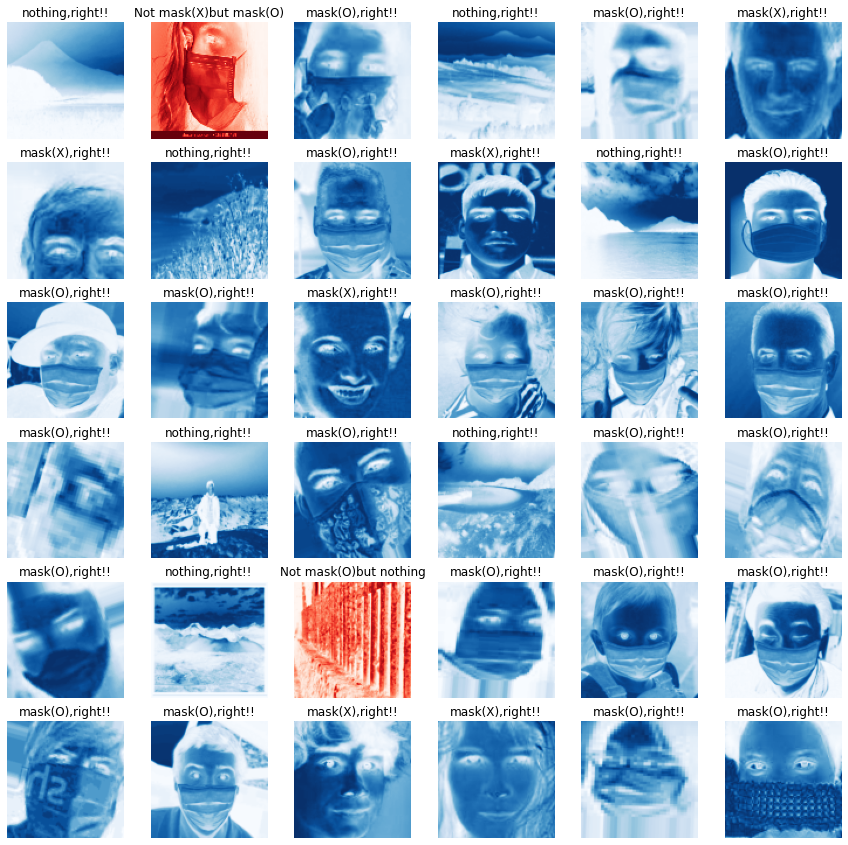

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
label_tags = {
    0:'nothing',
    1:'mask(O)',
    2:'mask(X)'
}
# 가로 6 세로를 6개 총 36개 사진을 15*15 크기로 나열
columns = 6
rows = 6
fig = plt.figure(figsize = (15, 15))
#무작위로 36개의 사진을 뽑아서 test 결과를 보여줌
net.eval()
for i in range(1, columns * rows +1):
  data_idx = np.random.randint(len(masktest))
  imput_img = masktest[data_idx][0].unsqueeze(dim = 0).to('cuda:0')
  output = net(imput_img)
  _, argmax = torch.max(output, 1)
  pred = label_tags[argmax.item()]
  label = label_tags[masktest[data_idx][1]]
#올바르게 나왔으면 right이라고 표현 하면서 파란색으로 나타나고 아니면 but nothing이라고 표현하면서 빨간색으로 나타냄
  fig.add_subplot(rows, columns, i)
  if pred == label:
    plt.title(pred + ',right!!')
    cmap = 'Blues'
  else:
    plt.title('Not ' + pred +'but ' + label)
    cmap = 'Reds'
  plot_img = masktest[data_idx][0][0, :, :]
  plt.imshow(plot_img, cmap = cmap)
  plt.axis('off')
plt.show()

In [ ]:
#pip install youtube_dl

In [ ]:
#pip install pafy

In [ ]:
#모델과 미리 학습된 가중치 가져오기
PATH = '/content/drive/MyDrive/Project_mask/weights/trained.pth'
model = Net().to('cuda:0')
model.load_state_dict(torch.load(PATH))
model.eval()

Net()

In [ ]:
import numpy as np
import cv2
import os
faceCascade = cv2.CascadeClassifier('/content/drive/MyDrive/Project_mask/haarcascade_frontalface_default.xml')
#캐스캐이드 분류기와 미리 학습된 얼굴 분류데이터 사용으로 영상에서 얼굴 추출하기

In [ ]:
#얼굴을 찾은 후 좌표 추출 및 얼굴 크롭

path = '/content/drive/MyDrive/Project_mask/testjpg/people'
def detect(gray, frame):
  faces = faceCascade.detectMultiScale(gray, scaleFactor = 1.05, minNeighbors = 3, minSize = (50, 50), flags = cv2.CASCADE_SCALE_IMAGE)
  i = 0
  for (x, y, w, h) in faces:
    cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
    face_gray = gray[y : y + h, x : x + w]
    face_color = frame[y : y + h, x : x + w]
    crop_img = face_color.copy()
    cv2.imwrite(os.path.join(path ,'people{:>05}.jpg'.format(i)), crop_img) #크롭한 얼굴 저장
    i += 1

  return frame

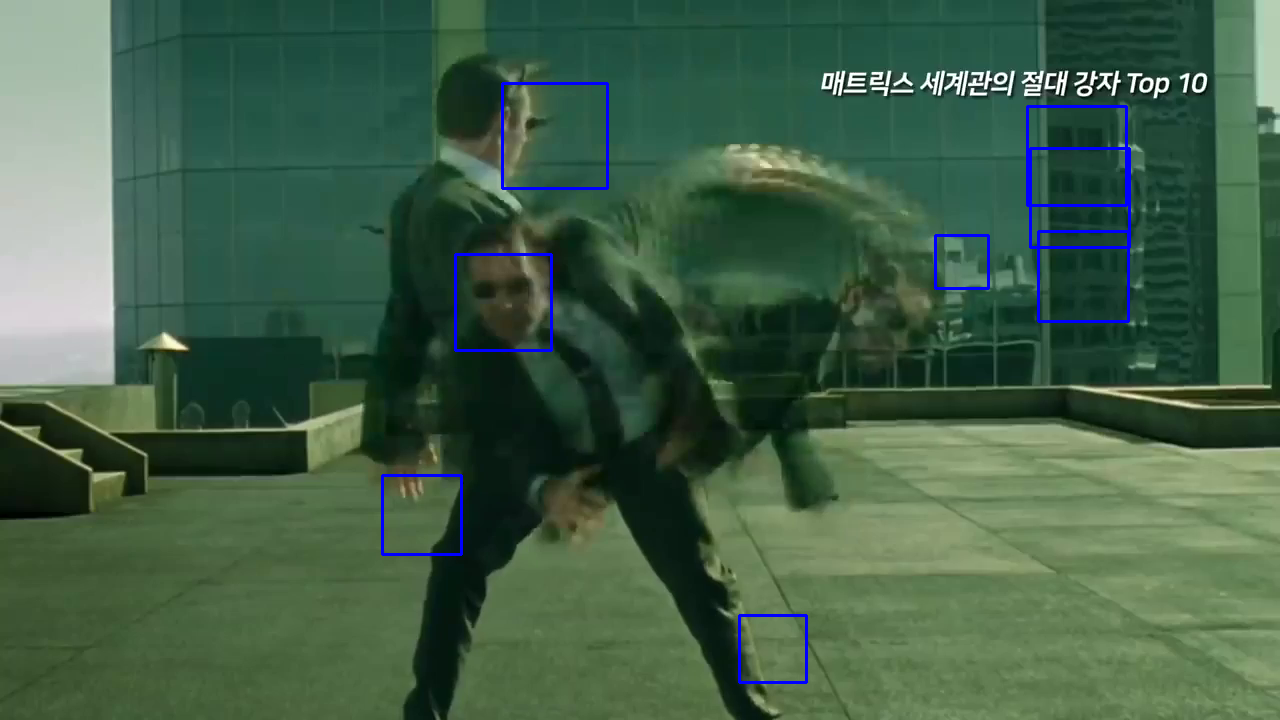

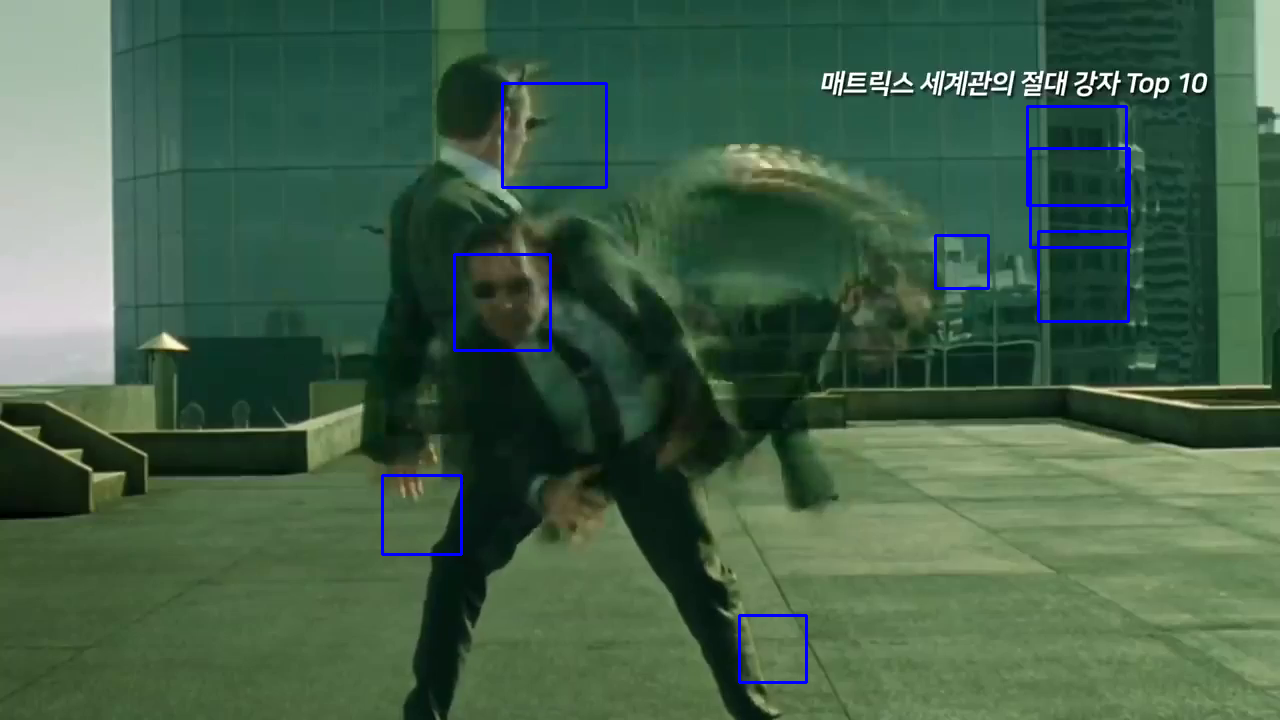

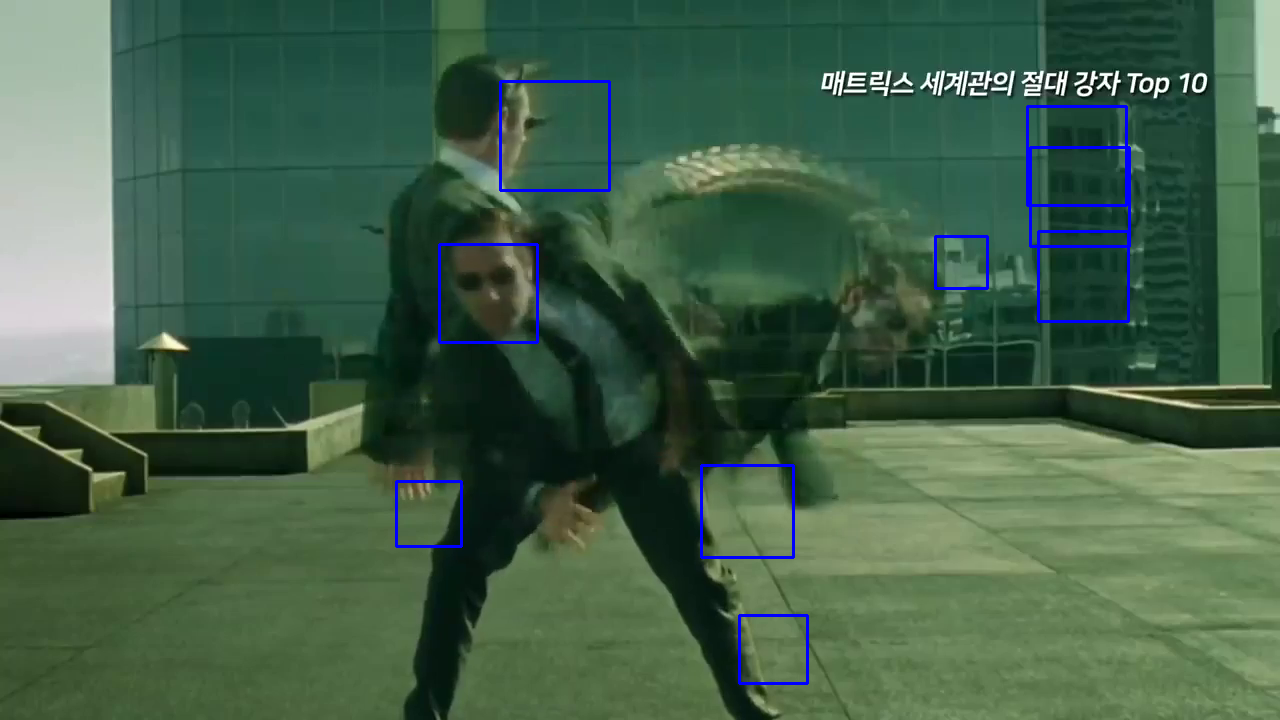

KeyboardInterrupt: ignored

In [ ]:
#영상에서 사람 얼굴 찾기

from google.colab.patches import cv2_imshow
cap = cv2.VideoCapture('/content/drive/MyDrive/Project_mask/video2.mp4')
frameSpeed = cap.get(cv2.CAP_PROP_FPS)
while True:

  _, frame = cap.read()
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  canvas = detect(gray, frame)
  cv2_imshow(canvas)
  #cv2.imwrite('/content/drive/MyDrive/Project_mask/face/',cropimg)
  if cv2.waitKey(1) & 0xff == ord('1'):
    break

cap.release()
cv2.destroyAllWindows()

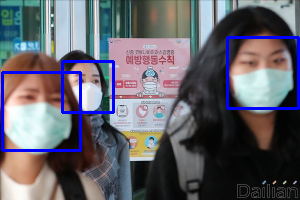

In [ ]:
#사진에서 사람얼굴 찾기

from google.colab.patches import cv2_imshow
#코랩에서는 opencv의 cv2.imshow명령어가 실행불가함으로 코랩 패치를 통한 cv2_imshow 가져오기

src =  cv2.imread('/content/drive/MyDrive/Project_mask/people7.png')#영상 가져오기
img_ori = cv2.resize(src, dsize=(0, 0), fx=0.5, fy=0.5)             #영상 1/2로 줄이기
img = img_ori.copy()#이미지 카피
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)                        #이미지 컬러에서 흑백영상으로 변환
canvas = detect(gray, img)                                          #흑백영상과 컬러영상을 detect함수로 보내어 사람 얼굴 찾기
cv2_imshow(canvas)                                                  #영상 보여주기
#cv2.imwrite('/content/drive/MyDrive/Project_mask/face/',cropimg)

In [ ]:
print(img.shape)

(200, 300, 3)


In [ ]:
#실시간 카메라로 사진찍어서 얼굴찾기 colab 기능을 이용

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
#  사진에서 사람얼굴 찾기
from google.colab.patches import cv2_imshow
# 실시간으로 찍은 사진에서 사람 얼굴 찾기
src =  cv2.imread('/content/photo.jpg')
img_ori = cv2.resize(src, dsize=(0, 0), fx=0.5, fy=0.5)
img = img_ori.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
canvas = detect(gray, img)
cv2_imshow(canvas)

In [ ]:
#찾은 얼굴사진 사이즈변경

trans = transforms.Compose([transforms.Resize((100, 100)),
                             transforms.ToTensor(),
                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                             ])
testjpg = torchvision.datasets.ImageFolder(root = '/content/drive/MyDrive/Project_mask/testjpg',
                                             transform = trans)
testjpg_loader = torch.utils.data.DataLoader(dataset = masktest,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=False)

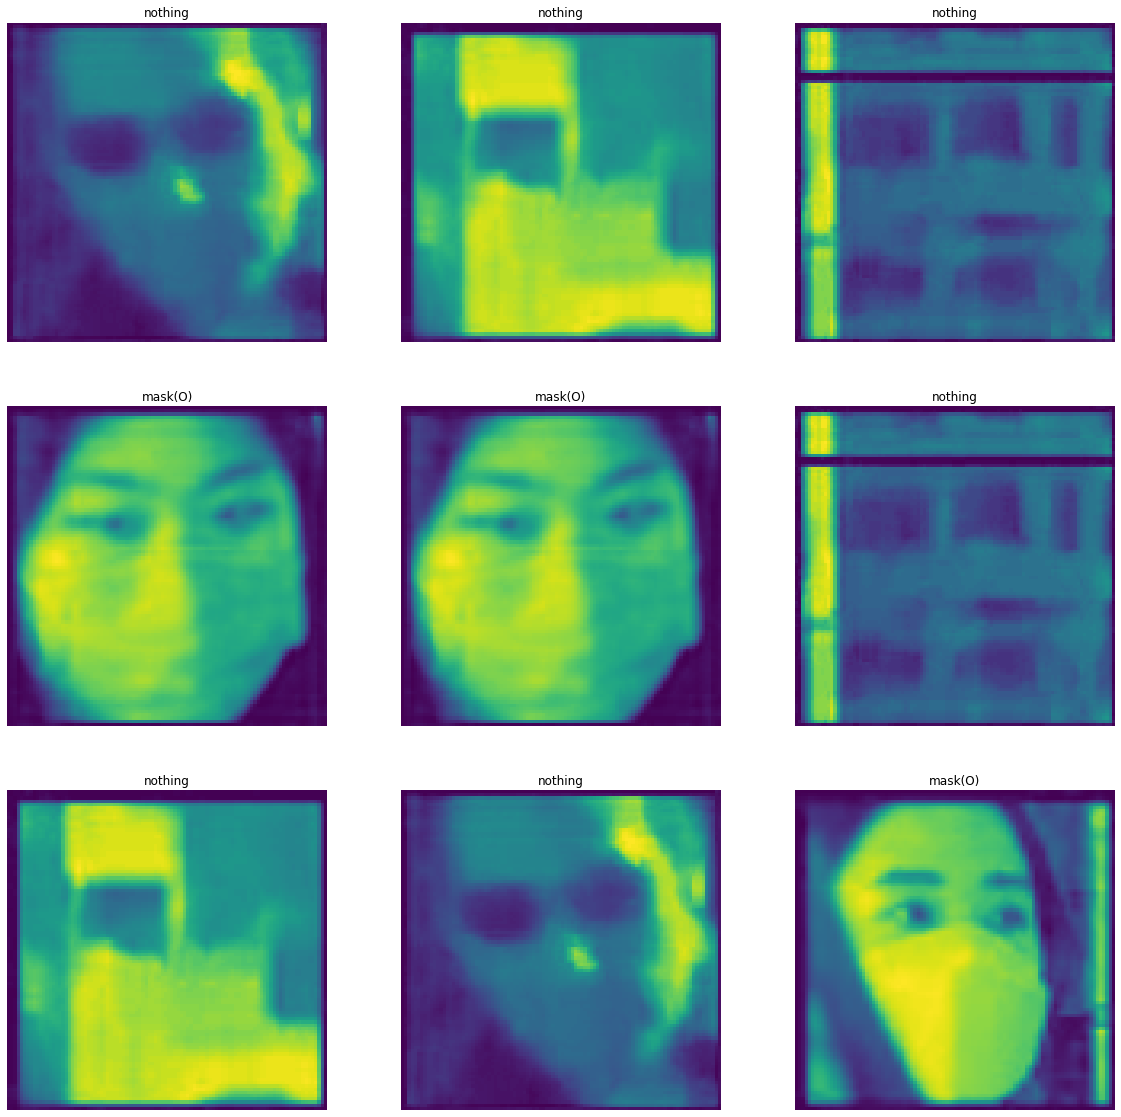

In [ ]:
# Main Code에서 사용한거 그대로 응용
import numpy as np
import matplotlib.pyplot as plt

label_tags = {
    0:'nothing',
    1:'mask(O)',
    2:'mask(X)',
}
columns = 3
rows = 3
fig = plt.figure(figsize = (20, 20))

net.eval()
for i in range(1, columns * rows +1):
  data_idx = np.random.randint(len(testjpg))
  imput_img = testjpg[data_idx][0].unsqueeze(dim = 0).to('cuda:0')
  output = net(imput_img).to('cuda:0')
  _, argmax = torch.max(output, 1)
  pred = label_tags[argmax.item()]

  fig.add_subplot(rows, columns, i)
  plt.title(pred)
  plot_img = testjpg[data_idx][0][0, :, :]
  plt.imshow(plot_img)
  plt.axis('off')
plt.show()